In [1]:
import os
os.chdir('..')

import random
import torch

import src.utils.utils as utils
import src.utils.dataset_loader as dataset_loader
import src.utils.similarity as similarity
import src.utils.model_loader as model_loader

import matplotlib
from matplotlib import pyplot as plt

/home/xueyi/.conda/envs/prob_cvcl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clip_name = 'ViT-B/16'
target_name = 'cvcl-resnext'
target_layer = 'vision_encoder.model.layer1,vision_encoder.model.layer2,vision_encoder.model.layer3,vision_encoder.model.layer4'.split(',')
d_probe = 'objects'
concept_set = 'data/baby+30k+konk.txt'
batch_size = 128
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = target_layer, 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

Loading checkpoint from /home/xueyi/.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/f50eaa0c50a6076a5190b1dd52aeeb6c3e747045/cvcl_s_dino_resnext50_embedding.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/f50eaa0c50a6076a5190b1dd52aeeb6c3e747045/cvcl_s_dino_resnext50_embedding.ckpt`


All specified layers' activations are already saved.


In [ ]:
with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = dataset_loader.get_dataset(d_probe, transform=None)

# examples of spurious neurons
neurons_data = {}
neurons_to_check = {
    'vision_encoder.model.layer1': 47,
    'vision_encoder.model.layer2': 365,
    'vision_encoder.model.layer3': 36,
    'vision_encoder.model.layer4': 1776
}

# Collect data for each layer
for layer, neuron_id in neurons_to_check.items():
    save_names = utils.get_save_names(
        clip_name=clip_name, 
        target_name=target_name,
        target_layer=layer, 
        d_probe=d_probe,
        concept_set=concept_set, 
        pool_mode=pool_mode,
        save_dir=save_dir
    )
    
    target_save_name, clip_save_name, text_save_name = save_names
    similarities, target_feats = utils.get_similarity_from_activations(
        target_save_name, 
        clip_save_name, 
        text_save_name, 
        similarity_fn
    )
    
    # Store relevant data
    neurons_data[layer] = {
        'neuron_id': neuron_id,
        'top_images': torch.topk(target_feats, k=3, dim=0)[1][:, neuron_id],
        'label': words[int(torch.topk(similarities[neuron_id], k=1, largest=True)[1])]
    }



100%|██████████| 256/256 [00:00<00:00, 262.56it/s]


torch.Size([256, 30427])


100%|██████████| 512/512 [00:03<00:00, 138.28it/s]


torch.Size([512, 30427])


100%|██████████| 1024/1024 [00:07<00:00, 143.37it/s]


torch.Size([1024, 30427])


100%|██████████| 2048/2048 [00:12<00:00, 167.13it/s]

torch.Size([2048, 30427])


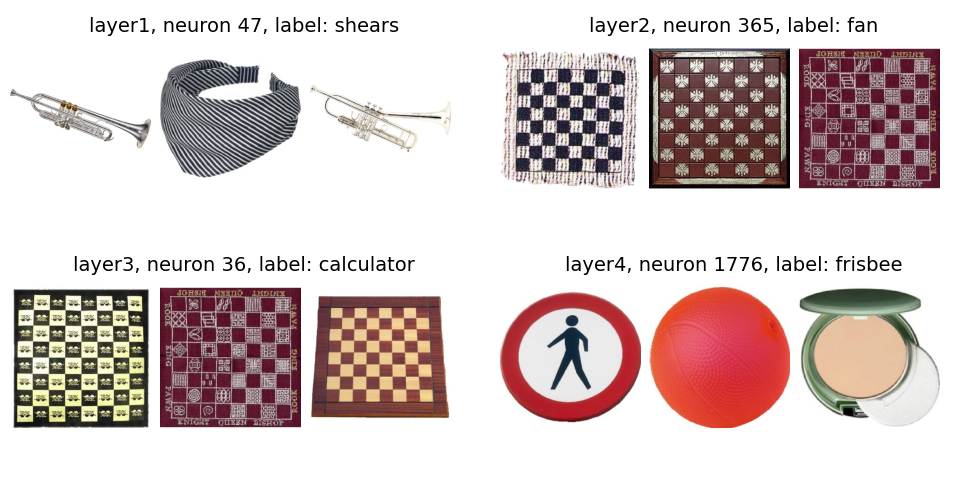

In [9]:
from torchvision import transforms

font_size = 14
font = {'size': font_size}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
layers = list(neurons_to_check.keys())
plt.tight_layout(h_pad=0.1,    
                w_pad=0.1)   

for idx, (layer, data) in enumerate(neurons_data.items()):
    row = idx // 2
    col = idx % 2
    
    # Create a subplot for the current layer
    layer_name = layer.split('.')[-1]
    axs[row, col].text(0.5, 0.9, 
                      f"{layer_name}, neuron {data['neuron_id']}, label: {data['label']}", 
                      ha='center', 
                      transform=axs[row, col].transAxes)
    
    # Create a horizontal grid of 3 images
    for i, top_id in enumerate(data['top_images']):
        im, _ = pil_data[top_id]
        if torch.is_tensor(im):
            im = transforms.ToPILImage()(im)
    
        im = im.resize([375, 375])
        
        # Add subplot within the main subplot
        width = 0.3 
        spacing = 0.32  
        x_start = i * spacing
        inner_ax = axs[row, col].inset_axes([x_start, 0, width, 1])
        inner_ax.imshow(im)
        inner_ax.axis('off')
    
    axs[row, col].axis('off')

plt.tight_layout()
# plt.savefig('figures/suprious_examples.pdf', bbox_inches='tight', dpi=300)

plt.show()